In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier

# Load the datasets
# columns_description = pd.read_csv("HomeCredit_columns_description.csv")
pos_cash_balance = pd.read_csv("POS_CASH_balance.csv")
pos_cash_balance.info()
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
installments_payments = pd.read_csv("installments_payments.csv")
previous_application = pd.read_csv("previous_application.csv")

# Specify the path to the 'application_train.csv' file
application_train = pd.read_csv("application_train.csv")

# Display the first few rows of each dataset for initial exploration
# print("Columns Description:")
# print(columns_description.head())

print("\nPOS Cash Balance:")
print(pos_cash_balance.head())

print("\nBureau:")
print(bureau.head())

print("\nBureau Balance:")
print(bureau_balance.head())

print("\nCredit Card Balance:")
print(credit_card_balance.head())

print("\nInstallments Payments:")
print(installments_payments.head())

print("\nPrevious Application:")
print(previous_application.head())

print("\nApplication Train:")
print(application_train.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB

POS Cash Balance:
   SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0       

In [4]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

In [5]:
numeric_columns = application_train.select_dtypes(include=['number']).columns
categorical_columns = application_train.select_dtypes(exclude=['number']).columns

# Impute missing values for numeric columns with the mean
numeric_imputer = SimpleImputer(strategy='mean')
application_train[numeric_columns] = numeric_imputer.fit_transform(application_train[numeric_columns])

# Impute missing values for categorical columns with a constant value (e.g., a placeholder)
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
application_train[categorical_columns] = categorical_imputer.fit_transform(application_train[categorical_columns])

# Encode categorical variables
application_train_encoded = pd.get_dummies(application_train)

# Split the data into features and target variable
X = application_train_encoded.drop('TARGET', axis=1)
y = application_train_encoded['TARGET']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Feature Engineering - Additional Steps

# 1. Polynomial Features for Numeric Variables
numeric_columns = application_train.select_dtypes(include=['number']).columns
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(application_train[numeric_columns])

# Get the feature names
poly_feature_names = [f"poly_{i}" for i in range(X_poly.shape[1])]

# Create a DataFrame with polynomial features
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)
application_train_encoded = pd.concat([application_train_encoded, X_poly_df], axis=1)


# 2. Interaction Features
# Create interaction features between key variables
application_train_encoded['DAYS_EMPLOYED_ANNUITY_RATIO'] = application_train_encoded['DAYS_EMPLOYED'] / application_train_encoded['AMT_ANNUITY']

# 3. Aggregated Features
# Create aggregated features based on grouping certain variables
grouped_df = application_train.groupby('REGION_POPULATION_RELATIVE')['AMT_INCOME_TOTAL'].agg(['mean', 'median', 'std']).reset_index()
grouped_df.columns = ['REGION_POPULATION_RELATIVE', 'INCOME_MEAN_BY_REGION', 'INCOME_MEDIAN_BY_REGION', 'INCOME_STD_BY_REGION']
application_train_encoded = pd.merge(application_train_encoded, grouped_df, on='REGION_POPULATION_RELATIVE', how='left')

# 4. Age and Employment Duration
# Create features related to age and employment duration
application_train_encoded['AGE_EMPLOYED_RATIO'] = application_train_encoded['DAYS_BIRTH'] / application_train_encoded['DAYS_EMPLOYED']

# 5. Log Transformation
# Apply log transformation to skewed numeric variables
skewed_columns = application_train[numeric_columns].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew_columns = skewed_columns[abs(skewed_columns) > 0.5].index
application_train_encoded[high_skew_columns] = np.log1p(application_train_encoded[high_skew_columns])

# Update the target variable after feature engineering
y = application_train_encoded['TARGET']

# Display the first few rows of the updated dataset
print(application_train_encoded.head())

column_names = application_train_encoded.columns.tolist()
print(column_names)

C:\Users\USER\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
C:\Users\USER\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


   SK_ID_CURR    TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0    100002.0  0.693147           0.0         12.218500   12.915581   
1    100003.0  0.000000           0.0         12.506181   14.072865   
2    100004.0  0.000000           0.0         11.119898   11.813037   
3    100006.0  0.000000           0.0         11.813037   12.652947   
4    100007.0  0.000000           0.0         11.707678   13.148033   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0    10.114619        12.768544                    0.018626     -9461.0   
1    10.482892        13.937287                    0.003535    -16765.0   
2     8.817446        11.813037                    0.009982    -19046.0   
3    10.298481        12.601491                    0.007987    -19005.0   
4     9.992711        13.148033                    0.028260    -19932.0   

   DAYS_EMPLOYED  ...  poly_5772  poly_5773  poly_5774  poly_5775  poly_5776  \
0            NaN  ...   0.000000   0.00000

Confusion Matrix:
[[56378   176]
 [ 4750   199]]
Precision: 0.5306666666666666
Recall: 0.04021014346332592
F1-Score: 0.07475582268970697


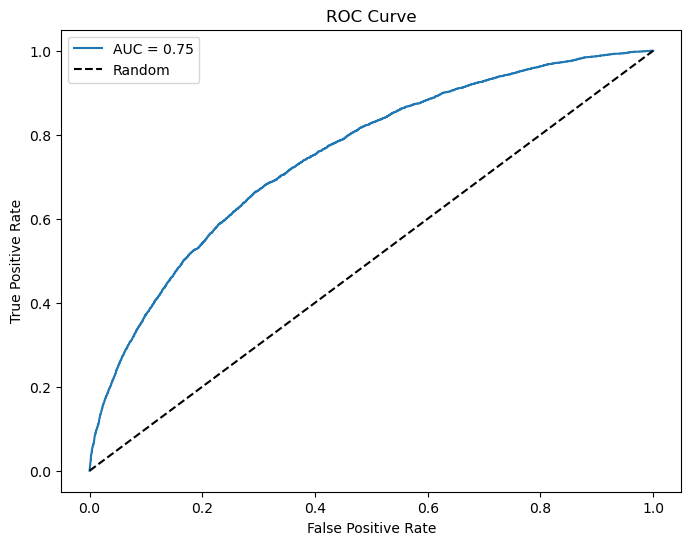

Feature Importance:
                                  Feature  Importance
30                           EXT_SOURCE_3    0.028293
29                           EXT_SOURCE_2    0.025096
107                         CODE_GENDER_F    0.017619
131  NAME_EDUCATION_TYPE_Higher education    0.017030
80                        FLAG_DOCUMENT_3    0.013880
..                                    ...         ...
94                       FLAG_DOCUMENT_17    0.000000
210            ORGANIZATION_TYPE_Religion    0.000000
89                       FLAG_DOCUMENT_12    0.000000
87                       FLAG_DOCUMENT_10    0.000000
125            NAME_INCOME_TYPE_Pensioner    0.000000

[251 rows x 2 columns]


In [7]:
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 2. Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# 3. ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 4. Feature Importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

In [8]:
# Initialize XGBoost model
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy*100)

# Optional: Feature importance analysis
feature_importance = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Feature Importance:")
print(feature_importance_df)

Model Accuracy: 91.99063460319009
Feature Importance:
                                  Feature  Importance
30                           EXT_SOURCE_3    0.028293
29                           EXT_SOURCE_2    0.025096
107                         CODE_GENDER_F    0.017619
131  NAME_EDUCATION_TYPE_Higher education    0.017030
80                        FLAG_DOCUMENT_3    0.013880
..                                    ...         ...
94                       FLAG_DOCUMENT_17    0.000000
210            ORGANIZATION_TYPE_Religion    0.000000
89                       FLAG_DOCUMENT_12    0.000000
87                       FLAG_DOCUMENT_10    0.000000
125            NAME_INCOME_TYPE_Pensioner    0.000000

[251 rows x 2 columns]


In [9]:
model.save_model('xgboost_model.json')